# Generative Adverserial Networks in PyTorch

Deep neural networks are used mainly for supervised learning: classification or regression. Generative Adverserial Networks or GANs, however, use neural networks for a very different purpose: Generative modeling

> Generative modeling is an unsupervised learning task in machine learning that involves automatically discovering and learning the regularities or patterns in input data in such a way that the model can be used to generate or output new examples that plausibly could have been drawn from the original dataset. - [Source](https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/)

While there are many approaches used for generative modeling, a Generative Adverserial Network takes the following approach: 

![GAN Flowchart](https://i.imgur.com/6NMdO9u.png)

There are two neural networks: a *Generator* and a *Discriminator*. The generator generates a "fake" sample given a random vector/matrix, and the discriminator attempts to detect whether a given sample is "real" (picked from the training data) or "fake" (generated by the generator). Training happens in tandem: we train the discriminator for a few epochs, then train the generator for a few epochs, and repeat. This way both the generator and the discriminator get better at doing their jobs. This rather simple approach can lead to some astounding results. The following images ([source](https://machinelearningmastery.com/resources-for-getting-started-with-generative-adversarial-networks/)), for instances, were all generated using GANs:

<img src="https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/04/Example-of-Photorealistic-Human-Faces-Generated-by-a-GAN.png" alt="gans_results" width="480">


GANs however, can be notoriously difficult to train, and are extremely sensitive to hyperparameters, activation functions and regularization. In this tutorial, we'll train a GAN to generate images of handwritten digits similar to those from the MNIST database.

<img src="https://i.imgur.com/CAYnuo1.jpg" width="360" >

Most of the code for this tutorial has been borrowed for this excellent repository of PyTorch tutorials: [github.com/yunjey/pytorch-tutorial](https://github.com/yunjey/pytorch-tutorial). Here's what we're going to do:

* Define the problem statement
* Load the data (with transforms and normalization)
    * Denormalize for visual inspection of samples
* Define the Discriminator network
    * Study the activation function: Leaky ReLU
* Define the Generator network
    * Explain the output activation function: TanH
    * Look at some sample outputs
* Define losses, optimizers and helper functions for training
    * For discriminator
    * For generator
* Train the model
    * Save intermediate generated images to file
* Look at some outputs
* Save the models
* Commit to Jovian.ml

## Imports

In [17]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from IPython.display import Image
from IPython.display import FileLink


## Load Data

In [2]:
mnist = MNIST(root='data', 
              train=True, 
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))])) # image pixels range changed from [0,1] to [-1,1]

## Helper Function

In [3]:
def denorm(x):
    out = (x + 1) / 2 # image [-1,1] to [0,1]
    return out.clamp(0, 1) 

## Display Sample Image

In [4]:
img, label = mnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  5
tensor([[[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000],
         [-1.0000,  0.0902,  0.9843,  0.4902, -0.9843],
         [-1.0000, -0.9137,  0.4902,  0.9843, -0.4510],
         [-1.0000, -1.0000, -0.7255,  0.8902,  0.7647],
         [-1.0000, -1.0000, -1.0000, -0.3647,  0.8824]]])


(tensor(-1.), tensor(1.))

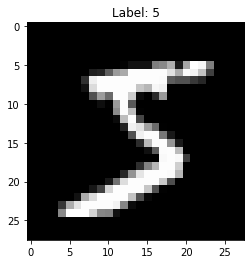

In [5]:
img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
plt.title(f"Label: {label}")
plt.show()

## Dataloader

In [6]:
# to load the images in batches.
batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([3, 2, 8, 6, 8, 4, 0, 1, 9, 0, 4, 0, 9, 9, 2, 1, 4, 6, 5, 1, 6, 0, 0, 6,
        1, 9, 2, 5, 0, 9, 8, 3, 5, 1, 0, 7, 2, 7, 8, 7, 2, 5, 6, 4, 8, 5, 2, 0,
        8, 8, 5, 8, 7, 7, 6, 0, 1, 2, 5, 3, 6, 3, 4, 8, 3, 2, 6, 1, 6, 0, 6, 1,
        1, 5, 0, 6, 8, 4, 5, 7, 0, 7, 3, 8, 1, 6, 6, 2, 3, 1, 9, 4, 8, 5, 1, 6,
        8, 5, 9, 0])


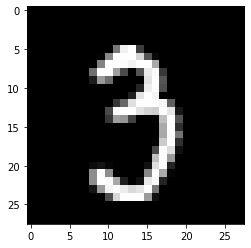

In [7]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [21]:
# create samples folder to save intermediate results
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [9]:
for images, _ in data_loader:
    print(images.size(), images.size(0))
    images = images.reshape(images.size(0), 1, 28, 28)
    print(images.size())
    # batch size is set to 100 , grayscale , 28x28
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

torch.Size([100, 1, 28, 28]) 100
torch.Size([100, 1, 28, 28])


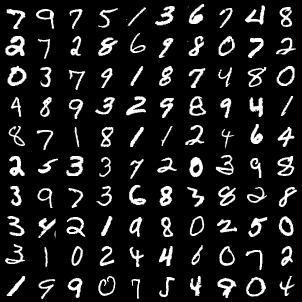

In [10]:
# Load image saved on pc  
Image(os.path.join(sample_dir, 'real_images.png'))

# Set Device

In [11]:
torch.cuda.is_available()

False

In [12]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Activation Functions

### Leaky ReLU

We use the Leaky ReLU activation for the discriminator.

<img src="https://cdn-images-1.medium.com/max/1600/1*ypsvQH7kvtI2BhzR2eT_Sw.png" width="420">


>  Different from the regular ReLU function, Leaky ReLU allows the pass of a small gradient signal for negative values. As a result, it makes the gradients from the discriminator flows stronger into the generator. Instead of passing a gradient (slope) of 0 in the back-prop pass, it passes a small negative gradient.  - [Source](https://sthalles.github.io/advanced_gans/)

Just like any other binary classification model, the output of the discriminator is a single number between 0 and 1, which can be interpreted as the probability of the input image being fake i.e. generated.

### TanH

We use the TanH activation function for the output layer of the generator.

<img src="https://nic.schraudolph.org/teach/NNcourse/figs/tanh.gif" width="420" >

> "The ReLU activation (Nair & Hinton, 2010) is used in the generator with the exception of the output layer which uses the Tanh function. We observed that using a bounded activation allowed the model to learn more quickly to saturate and cover the color space of the training distribution. Within the discriminator we found the leaky rectified activation (Maas et al., 2013) (Xu et al., 2015) to work well, especially for higher resolution modeling." - [Source](https://stackoverflow.com/questions/41489907/generative-adversarial-networks-tanh)


Note that since the outputs of the TanH activation lie in the range `[-1,1]`, we have applied the same transformation to the images in the training dataset. Let's generate an output vector using the generator and view it as an image by transforming and denormalizing the output.

## Discriminator Network

The discriminator takes an image as input, and tries to classify it as "real" or "generated". In this sense, it's like any other neural network. While we can use a CNN for the discriminator, we'll use a simple feedforward network with 3 linear layers to keep things since. We'll treat each 28x28 image as a vector of size 784.

In [13]:
image_size = 784
hidden_size = 256

In [14]:
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [15]:
D.to(device);

## Generator Network

The input to the generator is typically a vector or a matrix which is used as a seed for generating an image. Once again, to keep things simple, we'll use a feedfoward neural network with 3 layers, and the output will be a vector of size 784, which can be transformed to a 28x28 px image.

In [16]:
latent_size = 64

In [17]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [18]:
G.to(device);

## Visualize Random Noise

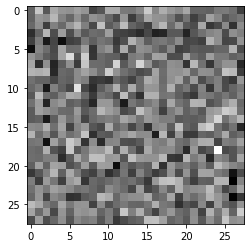

In [19]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach()) # detach association with tensor metadata
plt.imshow(gen_imgs[0], cmap='gray')
plt.show()

## Loss

Since the discriminator is a binary classification model, we can use the binary cross entropy loss function to quantify how well it is able to differentiate between real and generated images.

<img src="https://image.slidesharecdn.com/chrishokamp-dublinnlp3-160805110319/95/task-based-learning-for-nlp-going-beyond-cross-entropy-chris-hokamp-10-638.jpg?cb=1470395213" width="420" >

In [20]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [21]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

## Discriminator Training

In [22]:
def train_discriminator(images):
    # We expect the discriminator to output 1 for real image and 0 if it was generated. 
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
        
    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels) # labels set to 1 for real images
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels) # labels set to 0 for fake images
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    # we don't change the weights of the generator model while training the discriminator (`d_optimizer` only affects the `D.parameters()`)
    d_optimizer.step() 
    
    return d_loss, real_score, fake_score

## Generator Training

In [23]:
def train_generator():
    # Generate fake images -> send to discriminator 
    # we want fake images to be as real as possible so discriminator should predict label as 1
    # we want to fool the discrimator
    # calculate loss by setting lables to 1
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels) # discriminator is used as a part of the loss function

    # Backprop and optimize
    reset_grad() # grads set to 0
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

## Save Fake Images

In [24]:
def save_fake_images(index):
    sample_vectors = torch.randn(batch_size, latent_size).to(device) # keep this outside of function to get same random values
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

Saving fake_images-0000.png


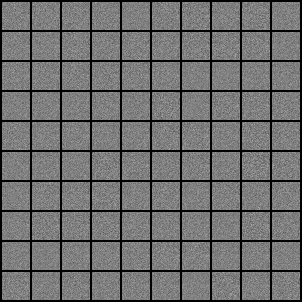

In [25]:
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

## Training the Model

In [ ]:
# train the discriminator first, and then the generator.

num_epochs = 500
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    count = 1
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 100 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            
            # Sample and save images
            save_fake_images((epoch+1)*10 + count)
            count += 1
            
    print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
          .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                  real_score.mean().item(), fake_score.mean().item()))
        

Saving fake_images-0011.png
Saving fake_images-0012.png
Saving fake_images-0013.png
Saving fake_images-0014.png
Saving fake_images-0015.png
Saving fake_images-0016.png
Epoch [0/500], Step [600/600], d_loss: 0.0607, g_loss: 4.9858, D(x): 0.97, D(G(z)): 0.03
Saving fake_images-0021.png
Saving fake_images-0022.png
Saving fake_images-0023.png
Saving fake_images-0024.png
Saving fake_images-0025.png
Saving fake_images-0026.png
Epoch [1/500], Step [600/600], d_loss: 0.0739, g_loss: 5.4846, D(x): 0.98, D(G(z)): 0.04
Saving fake_images-0031.png
Saving fake_images-0032.png
Saving fake_images-0033.png
Saving fake_images-0034.png
Saving fake_images-0035.png
Saving fake_images-0036.png
Epoch [2/500], Step [600/600], d_loss: 0.7803, g_loss: 2.8733, D(x): 0.74, D(G(z)): 0.11
Saving fake_images-0041.png
Saving fake_images-0042.png
Saving fake_images-0043.png
Saving fake_images-0044.png
Saving fake_images-0045.png
Saving fake_images-0046.png
Epoch [3/500], Step [600/600], d_loss: 1.1811, g_loss: 1.6576

## Save Checkpoints.

In [46]:
# Save the model checkpoints 
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

## Visualize Output

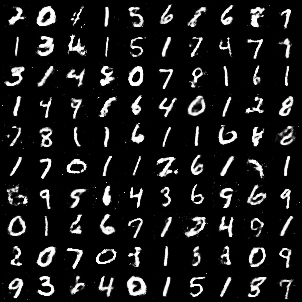

In [18]:
Image('./samples/fake_images-4035.png')

## Visualize Losses

In [15]:
d_losses = [0.97, 0.98, 0.74, 0.66, 0.97, 0.94, 0.97, 0.97, 0.99, 0.97, 0.98, 0.97, 0.97, 0.97, 0.96, 0.93, 0.97, 0.89, 0.87, 0.93, 0.93, 0.82, 0.92, 0.9, 0.8, 0.95, 0.91, 0.94, 0.93, 0.89, 0.93, 0.89, 0.91, 0.83, 0.91, 0.91, 0.78, 0.92, 0.87, 0.88, 0.9, 0.79, 0.83, 0.83, 0.85, 0.89, 0.82, 0.86, 0.81, 0.84, 0.82, 0.81, 0.74, 0.66, 0.77, 0.84, 0.9, 0.83, 0.87, 0.83, 0.77, 0.8, 0.79, 0.72, 0.79, 0.74, 0.72, 0.76, 0.8, 0.76, 0.74, 0.87, 0.78, 0.81, 0.8, 0.76, 0.81, 0.69, 0.68, 0.78, 0.79, 0.8, 0.7, 0.77, 0.74, 0.78, 0.76, 0.71, 0.64, 0.79, 0.77, 0.83, 0.75, 0.69, 0.76, 0.69, 0.8, 0.77, 0.8, 0.66, 0.76, 0.8, 0.78, 0.64, 0.67, 0.73, 0.68, 0.73, 0.69, 0.7, 0.68, 0.77, 0.75, 0.75, 0.68, 0.79, 0.77, 0.76, 0.71, 0.75, 0.76, 0.67, 0.72, 0.7, 0.74, 0.66, 0.73, 0.7, 0.71, 0.74, 0.72, 0.69, 0.57, 0.69, 0.76, 0.69, 0.71, 0.69, 0.72, 0.75, 0.75, 0.78, 0.75, 0.66, 0.73, 0.77, 0.63, 0.72, 0.76, 0.66, 0.75, 0.7, 0.72, 0.65, 0.72, 0.66, 0.66, 0.71, 0.7, 0.52, 0.73, 0.75, 0.73, 0.61, 0.65, 0.77, 0.72, 0.74, 0.71, 0.66, 0.64, 0.72, 0.67, 0.65, 0.67, 0.69, 0.71, 0.74, 0.74, 0.65, 0.69, 0.67, 0.7, 0.64, 0.75, 0.7, 0.72, 0.62, 0.6, 0.62, 0.7, 0.7, 0.73, 0.71, 0.71, 0.67, 0.74, 0.68, 0.68, 0.67, 0.71, 0.75, 0.59, 0.67, 0.72, 0.63, 0.7, 0.66, 0.63, 0.66, 0.76, 0.64, 0.63, 0.7, 0.61, 0.65, 0.65, 0.66, 0.66, 0.78, 0.71, 0.69, 0.7, 0.6, 0.7, 0.7, 0.73, 0.76, 0.58, 0.7, 0.62, 0.64, 0.63, 0.67, 0.63, 0.73, 0.64, 0.7, 0.67, 0.67, 0.63, 0.74, 0.69, 0.75, 0.66, 0.74, 0.72, 0.66, 0.68, 0.66, 0.64, 0.69, 0.69, 0.65, 0.71, 0.62, 0.67, 0.74, 0.73, 0.69, 0.74, 0.62, 0.67, 0.67, 0.67, 0.65, 0.68, 0.7, 0.68, 0.6, 0.59, 0.66, 0.72, 0.64, 0.66, 0.65, 0.73, 0.71, 0.65, 0.61, 0.69, 0.67, 0.66, 0.7, 0.73, 0.66, 0.71, 0.71, 0.73, 0.64, 0.65, 0.73, 0.67, 0.71, 0.6, 0.67, 0.7, 0.7, 0.69, 0.63, 0.76, 0.7, 0.77, 0.73, 0.69, 0.72, 0.67, 0.73, 0.71, 0.66, 0.71, 0.7, 0.62, 0.73, 0.69, 0.64, 0.69, 0.74, 0.66, 0.67, 0.71, 0.67, 0.69, 0.66, 0.62, 0.75, 0.81, 0.76, 0.64, 0.65, 0.63, 0.63, 0.69, 0.72, 0.69, 0.64, 0.63, 0.7, 0.67, 0.65, 0.75, 0.67, 0.63, 0.63, 0.78, 0.69, 0.74, 0.66, 0.66, 0.66, 0.75, 0.63, 0.73, 0.72, 0.69, 0.69, 0.76, 0.63, 0.74, 0.7, 0.71, 0.71, 0.72, 0.64, 0.65, 0.73, 0.66, 0.68, 0.73, 0.7, 0.66, 0.68, 0.72, 0.73, 0.73, 0.71, 0.7, 0.76, 0.66, 0.72, 0.7, 0.68, 0.66, 0.69, 0.67, 0.73, 0.7, 0.64, 0.71, 0.68, 0.7, 0.69, 0.72, 0.65, 0.69, 0.71, 0.7, 0.72, 0.71, 0.63, 0.7]
g_losses = [0.03, 0.04, 0.11, 0.32, 0.02, 0.05, 0.01, 0.0, 0.03, 0.0, 0.0, 0.01, 0.02, 0.02, 0.07, 0.1, 0.12, 0.13, 0.1, 0.11, 0.1, 0.06, 0.09, 0.04, 0.04, 0.06, 0.04, 0.05, 0.13, 0.17, 0.17, 0.13, 0.12, 0.04, 0.13, 0.15, 0.1, 0.18, 0.18, 0.2, 0.24, 0.18, 0.19, 0.18, 0.14, 0.17, 0.2, 0.28, 0.14, 0.17, 0.13, 0.14, 0.18, 0.17, 0.17, 0.17, 0.18, 0.2, 0.15, 0.15, 0.15, 0.16, 0.22, 0.1, 0.3, 0.18, 0.24, 0.15, 0.13, 0.23, 0.11, 0.17, 0.13, 0.19, 0.28, 0.2, 0.28, 0.14, 0.13, 0.27, 0.27, 0.28, 0.19, 0.26, 0.23, 0.31, 0.24, 0.19, 0.24, 0.2, 0.29, 0.24, 0.22, 0.32, 0.24, 0.17, 0.26, 0.2, 0.29, 0.21, 0.21, 0.24, 0.26, 0.14, 0.23, 0.17, 0.19, 0.35, 0.23, 0.23, 0.31, 0.25, 0.22, 0.21, 0.29, 0.24, 0.27, 0.23, 0.33, 0.25, 0.25, 0.28, 0.19, 0.24, 0.3, 0.19, 0.19, 0.27, 0.38, 0.21, 0.28, 0.28, 0.2, 0.32, 0.25, 0.23, 0.28, 0.26, 0.35, 0.31, 0.3, 0.39, 0.33, 0.28, 0.33, 0.29, 0.2, 0.32, 0.26, 0.3, 0.34, 0.25, 0.26, 0.36, 0.31, 0.28, 0.27, 0.34, 0.27, 0.2, 0.34, 0.34, 0.3, 0.29, 0.25, 0.33, 0.28, 0.41, 0.3, 0.26, 0.26, 0.25, 0.35, 0.31, 0.32, 0.27, 0.4, 0.39, 0.36, 0.33, 0.27, 0.35, 0.38, 0.33, 0.35, 0.29, 0.18, 0.17, 0.41, 0.29, 0.39, 0.33, 0.33, 0.31, 0.35, 0.36, 0.31, 0.42, 0.39, 0.28, 0.4, 0.4, 0.25, 0.33, 0.33, 0.24, 0.26, 0.26, 0.32, 0.31, 0.28, 0.36, 0.27, 0.32, 0.26, 0.32, 0.28, 0.3, 0.33, 0.43, 0.31, 0.36, 0.28, 0.26, 0.35, 0.4, 0.43, 0.38, 0.22, 0.37, 0.24, 0.39, 0.34, 0.34, 0.26, 0.34, 0.21, 0.38, 0.28, 0.33, 0.29, 0.34, 0.38, 0.38, 0.32, 0.37, 0.33, 0.31, 0.3, 0.28, 0.31, 0.36, 0.26, 0.26, 0.36, 0.24, 0.38, 0.31, 0.35, 0.3, 0.33, 0.22, 0.35, 0.32, 0.32, 0.36, 0.32, 0.3, 0.34, 0.23, 0.22, 0.21, 0.33, 0.24, 0.33, 0.31, 0.38, 0.34, 0.36, 0.34, 0.3, 0.35, 0.34, 0.29, 0.39, 0.21, 0.29, 0.33, 0.36, 0.33, 0.29, 0.32, 0.36, 0.31, 0.26, 0.4, 0.29, 0.37, 0.31, 0.28, 0.33, 0.26, 0.38, 0.28, 0.3, 0.34, 0.26, 0.38, 0.34, 0.38, 0.33, 0.29, 0.37, 0.29, 0.37, 0.29, 0.35, 0.33, 0.33, 0.33, 0.44, 0.42, 0.38, 0.26, 0.24, 0.38, 0.37, 0.39, 0.28, 0.25, 0.24, 0.32, 0.33, 0.27, 0.41, 0.36, 0.25, 0.34, 0.36, 0.26, 0.35, 0.36, 0.34, 0.32, 0.34, 0.38, 0.33, 0.29, 0.24, 0.31, 0.36, 0.29, 0.4, 0.34, 0.38, 0.35, 0.37, 0.26, 0.35, 0.28, 0.34, 0.33, 0.35, 0.32, 0.33, 0.37, 0.28, 0.28, 0.33, 0.31, 0.27, 0.3, 0.4, 0.43, 0.33, 0.3, 0.35, 0.39, 0.29, 0.27, 0.32, 0.31, 0.38, 0.27, 0.3, 0.36, 0.32, 0.26, 0.29, 0.25, 0.39, 0.3, 0.38, 0.3, 0.35, 0.38, 0.37, 0.29, 0.34, 0.34, 0.32]
real_scores = [0.0607, 0.0739, 0.7803, 1.1811, 0.0753, 0.2263, 0.0536, 0.0573, 0.0486, 0.1575, 0.0253, 0.0942, 0.1336, 0.0704, 0.1563, 0.2715, 0.2262, 0.3963, 0.4787, 0.2561, 0.2735, 0.4011, 0.273, 0.2558, 0.6186, 0.1798, 0.214, 0.1237, 0.3639, 0.4472, 0.4346, 0.3566, 0.3674, 0.4892, 0.4389, 0.3472, 0.5967, 0.4098, 0.5863, 0.4856, 0.5716, 0.6676, 0.5464, 0.5368, 0.556, 0.4637, 0.6721, 0.6946, 0.5433, 0.4913, 0.5175, 0.5601, 0.7647, 0.9557, 0.7049, 0.4962, 0.4065, 0.6111, 0.4343, 0.5149, 0.7181, 0.5944, 0.6481, 0.733, 0.8721, 0.7091, 0.9195, 0.6133, 0.5066, 0.7192, 0.5923, 0.4259, 0.5434, 0.5442, 0.7577, 0.7027, 0.7504, 0.7304, 0.7729, 0.7351, 0.7237, 0.7101, 0.7548, 0.7554, 0.7611, 0.8399, 0.7826, 0.7415, 1.0041, 0.5751, 0.7902, 0.5785, 0.7032, 1.07, 0.7741, 0.7353, 0.6752, 0.6177, 0.7967, 0.9293, 0.6985, 0.6633, 0.7453, 0.8294, 0.9226, 0.6647, 0.8034, 1.004, 0.9103, 0.8546, 0.9612, 0.7096, 0.6851, 0.6914, 0.9923, 0.7084, 0.7102, 0.6926, 0.9442, 0.7351, 0.791, 0.9793, 0.6979, 0.8615, 0.8464, 0.8192, 0.6598, 0.8819, 1.0153, 0.7094, 0.827, 0.9397, 1.086, 1.0024, 0.6789, 0.8025, 0.8591, 0.9435, 0.9342, 0.8364, 0.8221, 0.968, 0.8601, 0.9478, 0.933, 0.7595, 0.911, 0.9824, 0.7176, 1.0124, 0.8811, 0.8127, 0.8038, 1.1013, 0.8871, 0.9494, 0.9418, 0.913, 0.8139, 1.0907, 0.992, 0.8699, 0.8496, 1.0845, 0.9211, 0.8177, 0.8491, 1.0612, 0.9184, 0.8941, 1.0017, 0.7763, 1.0531, 1.0464, 0.9458, 0.903, 1.1152, 1.021, 0.9408, 1.0419, 0.8462, 1.0099, 1.0456, 1.0673, 0.8901, 0.8892, 0.6704, 0.8726, 1.3549, 1.0068, 1.0759, 0.9876, 0.9018, 0.899, 1.0136, 1.0741, 0.8663, 1.1333, 1.1028, 0.9155, 1.0406, 0.9696, 1.0776, 1.0499, 0.8827, 0.894, 0.8296, 0.907, 1.0903, 0.9462, 0.7238, 1.1909, 0.9772, 1.0141, 1.0506, 1.0348, 0.9591, 0.954, 1.0365, 1.0055, 0.8824, 1.0304, 0.8531, 1.0415, 1.0048, 1.0723, 1.1114, 0.9113, 0.9732, 1.0335, 0.9786, 1.15, 1.0972, 0.9566, 0.9565, 0.8629, 0.8927, 1.0468, 0.908, 0.9742, 1.0093, 0.8799, 1.0326, 0.9408, 1.0035, 0.9608, 0.9583, 1.0221, 0.9671, 0.9708, 1.0217, 1.0294, 0.8013, 0.9171, 1.0398, 0.9572, 1.1494, 0.7901, 0.9365, 0.8459, 0.8599, 0.9138, 1.0795, 0.9956, 1.0009, 1.0759, 0.9828, 0.8513, 0.9788, 0.993, 1.0262, 0.7931, 0.8883, 0.9004, 1.0674, 0.988, 0.977, 0.909, 1.0372, 1.0943, 0.9306, 0.9971, 1.0442, 0.8477, 0.991, 0.8435, 0.8475, 0.9532, 0.9309, 1.0671, 0.9238, 0.8629, 1.119, 0.8586, 0.9914, 1.0963, 0.856, 0.9901, 0.9275, 1.0504, 0.7945, 0.8053, 0.9819, 0.7921, 0.9145, 0.9016, 0.8778, 0.9728, 0.8959, 1.1263, 0.9078, 0.8986, 1.2001, 0.7597, 1.0192, 1.0347, 0.9668, 0.9079, 1.0328, 1.0262, 1.2452, 1.144, 1.0404, 0.933, 0.9089, 0.9499, 0.7841, 0.9902, 0.93, 0.8856, 0.9333, 1.0936, 0.9643, 0.7429, 1.1524, 1.0824, 0.9459, 0.9666, 1.0425, 0.9238, 0.8495, 1.0643, 1.0976, 1.0296, 0.8294, 1.0781, 0.8327, 0.9514, 0.8941, 0.93, 0.9304, 0.9962, 1.0468, 0.9678, 1.104, 1.0264, 0.8716, 0.916, 0.8985, 0.889, 0.9962, 0.9073, 0.9155, 1.0506, 1.0812, 0.9398, 0.9588, 0.9058, 0.877, 0.8637, 0.9033, 0.9379, 1.0925, 1.0726, 0.8751, 0.8691, 1.0154, 0.9887, 1.008, 0.8255, 0.94, 0.8896, 1.1172, 0.8724, 0.956, 0.9093, 0.9231, 0.9578, 0.8567, 0.8211, 1.1121, 0.9081, 0.9827, 0.9434, 1.0011, 1.0275, 0.9917, 0.8334, 0.9769, 1.1292, 0.9309]
fake_scores = [4.9858, 5.4846, 2.8733, 1.6576, 3.9373, 4.9147, 5.2424, 6.0062, 5.7829, 8.9627, 8.9269, 6.1826, 6.5016, 4.7586, 3.0554, 3.058, 4.2064, 4.7127, 4.5146, 4.3649, 4.3565, 5.0836, 3.4114, 4.1978, 4.1097, 5.476, 6.8553, 4.922, 3.5416, 2.7931, 4.2961, 3.9579, 2.745, 3.7848, 3.9857, 2.267, 2.248, 3.246, 3.7818, 2.6969, 2.4459, 3.4948, 2.5286, 3.0118, 4.291, 3.666, 3.2494, 2.8537, 2.4439, 2.5547, 2.4528, 2.9683, 1.8923, 1.9857, 2.8422, 2.9453, 2.3881, 2.5188, 2.4423, 3.1359, 3.3738, 3.2338, 2.362, 2.4339, 1.8027, 2.5049, 1.9586, 2.4558, 2.3001, 2.232, 3.2064, 2.9619, 2.5701, 2.269, 1.9425, 2.141, 2.2903, 1.9736, 2.8073, 2.038, 1.6986, 2.0637, 2.2575, 1.9818, 2.247, 2.4525, 1.438, 1.8139, 1.3682, 1.9551, 1.7561, 2.0135, 2.0606, 1.9917, 2.4067, 2.5283, 1.9442, 2.7597, 2.4256, 1.5658, 1.6847, 1.8794, 2.7586, 2.1398, 2.13, 1.8803, 2.5253, 2.0303, 1.93, 2.0501, 1.6188, 2.0084, 1.9456, 1.7523, 1.6788, 2.362, 2.2994, 1.8223, 1.4248, 1.9313, 2.1522, 1.6728, 2.1438, 1.8428, 2.1108, 2.0838, 2.0833, 2.1723, 1.3301, 1.8724, 1.961, 1.6621, 1.9317, 1.7588, 1.4483, 1.8327, 2.0735, 1.5017, 1.3632, 1.5342, 1.7683, 1.1305, 1.4163, 1.4931, 1.3254, 2.3129, 1.5933, 1.8331, 2.1108, 1.7753, 1.6114, 1.5204, 2.0445, 1.2266, 1.249, 1.7976, 1.4403, 1.1797, 1.4277, 1.735, 1.8021, 1.1112, 1.5534, 1.6251, 1.6393, 1.3256, 1.6921, 1.4078, 1.3732, 1.7912, 1.4572, 1.5347, 1.6275, 1.7261, 1.2434, 1.8502, 1.5353, 1.5446, 1.3624, 1.4209, 1.9534, 1.2406, 1.3491, 1.5519, 1.6115, 1.6959, 2.1254, 1.7899, 1.1208, 1.4383, 1.4882, 1.5823, 1.6046, 1.5167, 1.3806, 1.2251, 1.7014, 1.4094, 1.5225, 1.3147, 1.3017, 1.1931, 1.8444, 1.3923, 1.8118, 1.6055, 1.5568, 1.8083, 1.7474, 1.6981, 1.5946, 1.197, 1.2384, 1.9453, 1.2915, 1.5043, 1.6302, 1.7815, 1.4265, 1.354, 1.2103, 1.4531, 1.7446, 1.2543, 1.4179, 1.2023, 1.7007, 1.5225, 1.3501, 1.3445, 1.8361, 1.3965, 1.4725, 1.3162, 1.6606, 1.5354, 1.8399, 1.401, 1.4949, 1.3133, 1.2501, 1.5814, 1.4229, 1.2797, 1.5334, 1.7609, 1.5694, 1.5539, 1.2785, 1.5221, 1.5551, 1.7545, 1.4772, 1.4902, 1.4632, 1.9399, 1.4319, 1.6281, 1.7877, 1.371, 1.5937, 1.6314, 1.6302, 1.4541, 1.7094, 1.465, 1.53, 1.6074, 1.4805, 1.5477, 1.625, 1.3848, 1.1817, 2.0634, 1.851, 1.4351, 1.1989, 1.4715, 1.1729, 1.4563, 1.6023, 1.2793, 1.2491, 1.4298, 1.4027, 1.755, 1.5729, 1.1765, 1.3604, 1.4573, 1.3845, 1.6822, 1.3227, 1.7539, 1.5781, 1.1981, 1.2499, 1.317, 1.7391, 1.4506, 1.249, 1.5862, 1.3385, 1.2863, 1.7918, 1.8094, 1.8092, 1.6054, 1.1811, 1.4147, 1.5429, 1.7156, 1.5852, 1.7372, 1.3746, 1.2528, 1.5876, 1.2606, 1.5419, 1.4908, 1.2569, 1.3183, 1.2282, 1.6349, 1.8817, 1.1742, 1.3482, 1.3849, 1.5441, 1.6077, 1.9331, 1.737, 1.4737, 1.6969, 1.4157, 1.1674, 1.6311, 1.2466, 1.4943, 1.4743, 1.0422, 1.4259, 1.1998, 1.5582, 1.5194, 1.6414, 1.3122, 1.6819, 1.5455, 1.2492, 1.5228, 1.32, 1.2071, 1.3902, 1.2821, 1.6075, 1.2546, 1.3316, 1.2761, 1.6532, 2.0509, 1.4277, 1.2223, 1.5224, 1.3975, 1.4922, 1.3435, 1.6251, 1.4995, 1.3315, 1.5488, 1.388, 1.3769, 1.2533, 1.5307, 1.2326, 1.2734, 1.6522, 1.5194, 1.5631, 1.5992, 1.3751, 1.5117, 1.2711, 1.4098, 1.5659, 1.5735, 1.2102, 1.341, 1.8005, 1.546, 1.4828, 1.1249, 1.5696, 1.2307, 1.6682, 1.0754, 1.5319, 1.8833, 1.3108, 1.4523]

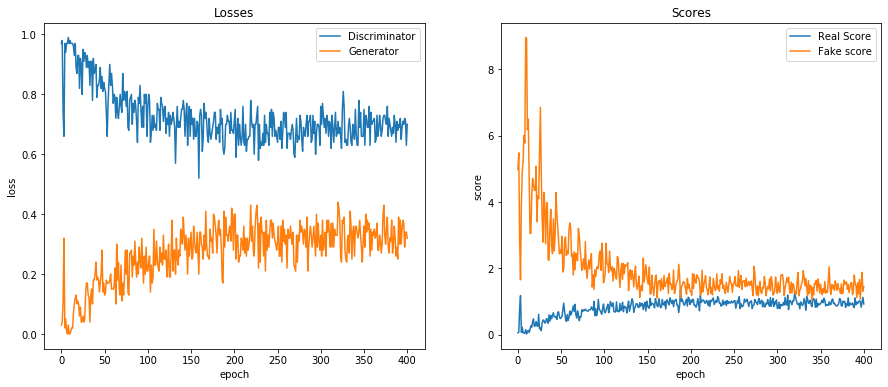

In [19]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')
plt.grid(False)

plt.subplot(1,2,2)
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores')
plt.grid(False)

plt.show()

## Convert Saved Images to Video

In [25]:
vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 24, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
# FileLink('gans_training.avi')

## All Code Combined

In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 200
batch_size = 100
sample_dir = 'samples'

# Create a directory if not exists
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# Image processing
# transform = transforms.Compose([
#                 transforms.ToTensor(),
#                 transforms.Normalize(mean=(0.5, 0.5, 0.5),   # 3 for RGB channels
#                                      std=(0.5, 0.5, 0.5))])
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5],   # 1 for greyscale channels
                                     std=[0.5])])

# MNIST dataset
mnist = torchvision.datasets.MNIST(root='../../data/',
                                   train=True,
                                   transform=transform,
                                   download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size=batch_size, 
                                          shuffle=True)

# Discriminator
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

# Generator 
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

# Device setting
D = D.to(device)
G = G.to(device)

# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

# Start training
total_step = len(data_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)
        
        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Compute loss with fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        
        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels)
        
        # Backprop and optimize
        reset_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
    
    # Save real images
    if (epoch+1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
    
    # Save sampled images
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))

# Save the model checkpoints 
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

# END